# 指数関数型シナプスモデル
シナプスのモデルは複数あるが, 良く用いられるのが**指数関数型シナプスモデル**(exponential synapse model)である．このモデルは生理学的な過程を無視した現象論的モデルであることに注意しよう．指数関数型シナプスモデルには2つの種類, **単一指数関数型モデル** (single exponential model)と**二重指数関数型モデル** (double exponential model)がある．

数式の説明の前にモデルの挙動を示す．次図は2種類のモデルにおいて$t=0$でスパイクが生じてからのシナプス後電流の変化を示している．ただし, 実際のシナプス後電流はこれに**シナプス強度** (Synaptic strength)[^synstr]を乗じて総和を取ったものとなる．

[^synstr]: シナプス強度というのは便宜上の呼称で, 実際には神経伝達物質の種類や, その受容体の数など複数の要因によって決定されている. また, このシナプス強度はシナプス重みということもある．これはどちらかと言えば機械学習の表現に引っ張られたものである．このため, このサイトでは重みという語も使う．

In [1]:
using PyPlot
rc("axes.spines", top=false, right=false)

In [4]:
td, tr = 2e-2, 2e-3 # synaptic decay time, synaptic rise time (sec)
dt, T = 5e-5, 0.1 # タイムステップ, シミュレーション時間 (sec)
nt = Int(T/dt) # シミュレーションの総ステップ

# 単一指数関数型シナプス
r_single = zeros(nt)
for t in 1:nt-1
    spike = ifelse(t == 1, 1, 0)
    r_single[t+1] = r_single[t]*(1-dt/td) + spike/td
    #r_single[t+1] = r_single[t]*exp(-dt/td) + spike/td
end

# 二重指数関数型シナプス
r_double, hr = zeros(nt), zeros(nt)
for t in 1:nt-1
    spike = ifelse(t == 1, 1, 0)
    r_double[t+1] = r_double[t]*(1-dt/tr) + hr[t]*dt
    hr[t+1] = hr[t]*(1-dt/td) + spike/(tr*td)
    #r_double[t+1] = r_double[t]*exp(-dt/tr) + hr[t]*dt
    #hr[t+1] = hr[t]*exp(-dt/td) + spike/(tr*td)
end   

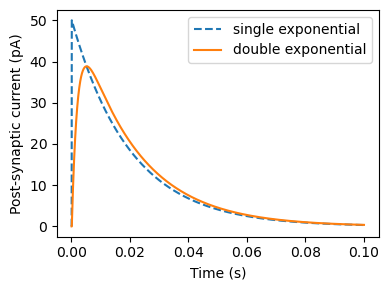

In [5]:
time = (1:nt)*dt
figure(figsize=(4, 3))
plot(time, r_single, linestyle="dashed", label="single exponential")
plot(time, r_double, label="double exponential")
xlabel("Time (s)"); ylabel("Post-synaptic current (pA)")
legend(); tight_layout()

2種類の指数関数型シナプスの動態．破線は単一指数関数型シナプスで, 実線は二重指数関数型シナプスである．

## 単一指数関数型モデル(Single exponential model)
シナプス前ニューロンにおいてスパイクが生じてからのシナプス後電流の変化はおおよそ指数関数的に減少する, というのが単一指数関数型モデルである [^comp]. 式は次のようになる．

[^comp]: 薬学動態の静注1コンパートメントモデルと同じ式である．

$$
\begin{equation}
f(t)=\frac{1}{\tau_{s}}\exp\left(-\frac{t}{\tau_s}\right)    
\end{equation}
$$

この関数を時間的なフィルターとして, 過去の全てのスパイクについての総和を取る．

$$
\begin{equation}
r(t)=\sum_{t_{k}< t} f\left(t-t_{k}\right)
\end{equation}
$$

ここで${r(t)}$は前節におけるシナプス動態($s_{\text{syn}}$)で, $t_{k}$はあるニューロンの$k$番目のスパイクの発生時刻である．${t_{k}<t}$の意味は現在の時刻$t$までに発生したスパイクについての和を取るという意味である．なお，スパイクが生じてから, ある程度の時間が経過した後はそのスパイクの影響はないと見なせるので, 一定の時間までの総和を取るのがよい．

別の表記法としてスパイク列に対する畳み込みを行うというものもある．畳み込み演算子を$*$とし, シナプス前細胞のスパイク列を$S(t)=\sum_{t_{k}< t} \delta\left(t-t_{k}\right)$とする (ただし, $\delta$はDiracのdelta関数において$\delta(0)=1$とした関数)．このとき, $r(t)=f*S(t)$と表すことができる．畳み込み演算子を用いると簡略な表記ができるが，実装上は他と同じ手法を用いる．

### 微分方程式による表現
上の手法ではニューロンの発火時刻を記憶し, 時間毎に全てのスパイクについての和を取る必要がある．そこで, 実装する場合は次の等価な微分方程式を用いる．

$$
\begin{equation}
\frac{dr}{dt}=-\frac{r}{\tau_{s}}+\frac{1}{\tau_{s}} \sum_{t_{k}< t} \delta\left(t-t_{k}\right)   
\end{equation}
$$

ここで$\tau_s$はシナプスの時定数(synaptic time constant)である． また, $\delta(\cdot)$はDiracのdelta関数です(ただし$\delta(0)=1$です). これをEuler法で差分化すると 

$$
\begin{equation}
r(t+\Delta t)=\left(1-\frac{\Delta t}{\tau_{s}}\right)r(t)+\frac{1}{\tau_{s}}\delta_{t,t_{k}} 
\end{equation}
$$

となる．ここで$\delta_{t,t_{k}}$はKroneckerのdelta関数で, $t=t_{k}$のときに1, それ以外は0となる．また減衰度として$\left(1-\Delta  t/\tau_{d}\right)$の代わりに$\exp\left(-\Delta t/\tau_{d}\right)$を用いる場合もある．

## 二重指数関数型モデル(Double exponential model)
2重の指数関数によりシナプス後電流の立ち上がりも考慮するのが, 二重指数関数型モデル(Double exponential model)である[^comp2]．$t=0$にシナプス前細胞が発火したときのシナプス後電流の時間変化の関数は次のようになる．
[^comp2]: 薬学動態の内服1コンパートメントモデルと同じ式である．

$$
\begin{equation}
f(t)=A\left[\exp\left(-\frac{t}{\tau_d}\right)-\exp\left(-\frac{t}{\tau_r}\right)\right]    
\end{equation}
$$

ただし, ${\tau_r}$は立ち上がり時定数(synaptic rise time constant), ${\tau_d}$は減衰時定数(synaptic decay time constant)である．$\tau_{d}$は$\tau_{s}$と同じく神経伝達物質の減少速度を決定している．$A$は規格化定数で次のように表される．

$$
\begin{equation}
A=\frac{\tau_d}{\tau_d-\tau_r}\cdot \left(\frac{\tau_r}{\tau_d}\right)^\frac{\tau_r}{\tau_r-\tau_d}    
\end{equation}
$$

規格化定数$A$を乗じることで最大値が1となる．ただし, シミュレーションをする上で実際に規格化をする場合は少ない．

### $\alpha$関数
上記の式において, $\tau=\tau_{r}=\tau_{d}$の場合は $\boldsymbol{\alpha}$ **関数** (alpha function, alpha synapse)と呼ぶ ([Rall, 1967](https://pubmed.ncbi.nlm.nih.gov/6055351/))．式としては次のようになる．

$$
\begin{equation}
\alpha(t)=\frac{t}{\tau}\exp\left(1-\frac{t}{\tau}\right)    
\end{equation}
$$

この式は二重指数関数型シナプスの式に単に代入するだけでは導出できない．これらの式の対応については後述する．

### 微分方程式による表現
ここで, 二重指数関数型シナプスの式に対応する, 補助変数$h$を用いた微分方程式を導入する． 

$$
\begin{align} 
\frac{dr}{dt}&=-\frac{r}{\tau_{d}}+h\\
\frac{dh}{dt}&=-\frac{h}{\tau_{r}}+\frac{1}{\tau_{r} \tau_{d}} \sum_{t_{k}< t} \delta\left(t-t_{k}\right) 
\end{align} 
$$

単一指数関数型シナプスの場合と同様にEuler法で差分化すると 

$$
\begin{align} 
r(t+\Delta t)&=\left(1-\frac{\Delta t}{\tau_{d}}\right)r(t)+h(t)\cdot \Delta t\\ 
h(t+\Delta t)&=\left(1-\frac{\Delta t}{\tau_{r}}\right)h(t)+\frac{1}{\tau_{r}\tau_{d}} \delta_{t,t_{j k}}
\end{align}
$$

となる．

念のため, 微分方程式と元の式が一致することを確認しておこう．$t=0$のときにシナプス前細胞が発火したとし, それ以降の発火はないとする．このとき, $h(0)=1/\tau_{r}\tau_{d}, r(0)=0$ である．$h$についての微分方程式の解は

$$
\begin{equation}
h(t)=h(0)\cdot \exp\left(-\frac{t}{\tau_r}\right)    
\end{equation}
$$

となるので, これを$r$についての式に代入して

$$
\begin{equation}
\frac{dr}{dt}=-\frac{r}{\tau_{d}}+h(0)\cdot \exp\left(-\frac{t}{\tau_r}\right) 
\end{equation}
$$

となる．これを解くには両辺に積分因子$\exp({t}/{\tau_d})$をかけてから積分をするかLaplace変換をするかである．今回はLaplace変換を用いる．右辺一項目を移行した後に両辺をLaplace変換すると以下のようになる．

$$
\begin{align}
\mathcal{L}\left[\frac{dr}{dt}+r/\tau_{d}\right]&=\mathcal{L}\left[h(0)\cdot \exp\left(-t/\tau_r\right)\right]\\
sF(s)-r(0)+\frac{1}{\tau_{d}}F(s)&=\frac{h(0)}{s+1/\tau_r}\\
F(s)&=\frac{h(0)}{(s+1/\tau_r)(s+1/\tau_d)}
\end{align}
$$

ただし$r(t)$のLaplace変換を$F(s)$とした. ここで逆Laplace変換を行うと次のようになる．

$$
\begin{align}
r(t)&=\mathcal{L}^{-1}(F(s))\\
&=\mathcal{L}^{-1}\left[\frac{h(0)}{(s+1/\tau_r)(s+1/\tau_d)}\right]\\
&=\mathcal{L}^{-1}\left[\frac{h(0)}{1/\tau_r-1/\tau_d}\left(\frac{1}{s+1/\tau_d}-\frac{1}{s+1/\tau_r}\right)\right]\\
&=\frac{1}{\tau_d-\tau_r}\left[\exp(-t/\tau_d)-\exp(-t/\tau_r)\right]
\end{align}
$$

この式の最大値$r_{\max}$を求めておこう． $r(t)$を微分して0と置いた式の解$t_{\max}$を代入すれば求められる．計算すると, 

$$
\begin{equation}
t_{\max}=\dfrac{\ln(\tau_d/\tau_r)}{1/\tau_r-1/\tau_d},\ \ r_{\max}=\dfrac{1}{\tau_{d}}\cdot \left(\dfrac{\tau_{r}}{\tau_{d}}\right)^{\frac{\tau_{r}}{\tau_d-\tau_{r}}}    
\end{equation}
$$

となる．

なお, $\alpha$関数の導出は逆Laplace変換をする前に$\tau=\tau_d=\tau_r$とすればよく, 

$$
\begin{align}
F_\alpha(s)&=\frac{h(0)}{(s+1/\tau)^2}\\
\alpha(t)&=\frac{t}{\tau^2}\exp\left(-\frac{t}{\tau}\right)
\end{align}
$$
となる．若干の係数の違いはあるが, 同じ形の関数が導出された． 